<a href="https://colab.research.google.com/github/w4bo/AA2526-unibo-mldm/blob/master/slides/lab-06-housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The [`California Housing`](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) case study

Our task is to use California census data to forecast housing prices given the population, median income, and median housing price for each block group in California.
Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).
We will just call them "districts" for short.

## Solution of the previous `Hands on`

In [36]:
#| echo: false
#| output: false

!pip install flaml[automl]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [37]:
def preprocess(normalize=True):
    df = pd.read_csv("https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/housing.csv", delimiter=",")
    num_df = df.drop(columns=["ocean_proximity", "median_house_value"])
    # Filling in (i.e., impute) missing values with the median value
    num_df["total_bedrooms"] = num_df["total_bedrooms"].fillna(num_df["total_bedrooms"].median())
    # Add a new column: population_per_household = population / households
    num_df["population_per_household"] = num_df["population"] / num_df["households"]
    # Add a new column: rooms_per_household = total_rooms / households
    num_df["rooms_per_household"] = num_df["total_rooms"] / num_df["households"]
    # Add a new column: bedrooms_per_room = total_bedrooms / total_rooms
    num_df["bedrooms_per_room"] = num_df["total_bedrooms"] / num_df["total_rooms"]
    if normalize:
        # Apply standardization to all the numeric columns
        num_df = (num_df - num_df.mean()) / num_df.std()
    # One hot encode `ocean_proximity` since it is a categorical attribute
    cat_df = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')
    # Join all the dataframes
    return pd.concat([num_df, cat_df, df[["median_house_value"]]], axis=1)


df = preprocess()
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,-1.327803,1.052523,0.982119,-0.804800,-0.972453,-0.974405,-0.977009,2.344709,-0.049595,0.628544,-1.029963,False,False,False,True,False,452600.0
1,-1.322812,1.043159,-0.607004,2.045841,1.357111,0.861418,1.669921,2.332181,-0.092510,0.327033,-0.888876,False,False,False,True,False,358500.0
2,-1.332794,1.038478,1.856137,-0.535733,-0.827004,-0.820757,-0.843616,1.782656,-0.025842,1.155592,-1.291654,False,False,False,True,False,352100.0
3,-1.337785,1.038478,1.856137,-0.624199,-0.719706,-0.766010,-0.733764,0.932945,-0.050328,0.156962,-0.449602,False,False,False,True,False,341300.0
4,-1.337785,1.038478,1.856137,-0.462393,-0.612408,-0.759828,-0.629142,-0.012881,-0.085614,0.344702,-0.639071,False,False,False,True,False,342200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758808,1.801603,-0.289180,-0.444974,-0.388274,-0.512579,-0.443438,-1.216099,-0.049109,-0.155020,0.165990,False,True,False,False,False,78100.0
20636,-0.818702,1.806285,-0.845373,-0.888682,-0.922380,-0.944382,-1.008396,-0.691576,0.005021,0.276874,0.021670,False,True,False,False,False,77100.0
20637,-0.823693,1.778194,-0.924829,-0.174991,-0.123605,-0.369528,-0.174037,-1.142566,-0.071733,-0.090316,0.021134,False,True,False,False,False,92300.0
20638,-0.873605,1.778194,-0.845373,-0.355591,-0.304820,-0.604415,-0.393743,-1.054557,-0.091223,-0.040210,0.093464,False,True,False,False,False,84700.0


# Checking feature correlations

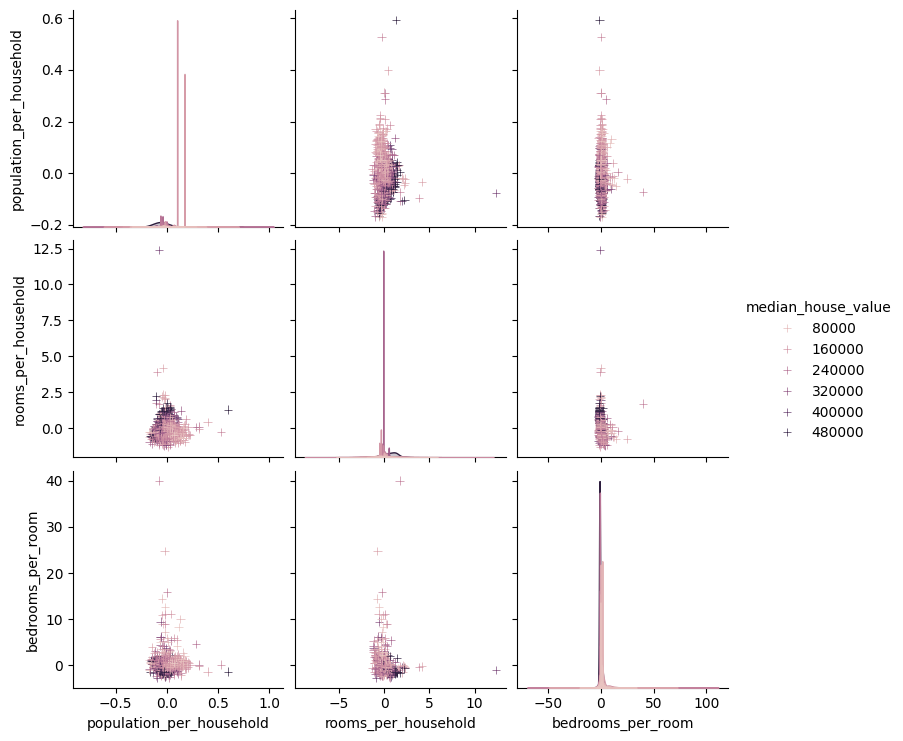

In [38]:
sns.pairplot(
    df[["population_per_household", "rooms_per_household", "bedrooms_per_room", "median_house_value"]].sample(n=1000, random_state=42),
    hue='median_house_value', markers='+'
)

# Splitting training and test data

In [39]:
from sklearn.model_selection import train_test_split
y = df["median_house_value"]  # labels
X = df.drop(columns=["median_house_value"])  # input data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (16512, 16)
X_test: (4128, 16)
y_train: (16512,)
y_test: (4128,)


In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   16512 non-null  float64
 1   latitude                    16512 non-null  float64
 2   housing_median_age          16512 non-null  float64
 3   total_rooms                 16512 non-null  float64
 4   total_bedrooms              16512 non-null  float64
 5   population                  16512 non-null  float64
 6   households                  16512 non-null  float64
 7   median_income               16512 non-null  float64
 8   population_per_household    16512 non-null  float64
 9   rooms_per_household         16512 non-null  float64
 10  bedrooms_per_room           16512 non-null  float64
 11  ocean_proximity_<1H OCEAN   16512 non-null  bool   
 12  ocean_proximity_INLAND      16512 non-null  bool   
 13  ocean_proximity_ISLAND      1651

# Regression

LinearRegression fits a linear model with coefficients $w = (w_1, ..., w_p)$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [41]:
from sklearn.linear_model import LinearRegression  # choose and import the model
lin_reg = LinearRegression(fit_intercept=True)  # choose model hyperparameters and initialize the model (i.e., the estimator)
lin_reg.fit(X_train, y_train)  # model fitting
lin_reg.coef_  # return the learned parameters

array([-56218.2257606 , -56621.04836643,  14103.74699543,   5900.12924673,
         5312.69799925, -46134.52612316,  40378.76502969,  78721.51735298,
          673.09498837,   7979.62051402,  18911.78683053, -18666.47855331,
       -53617.84037612, 112060.2444519 , -24109.18513167, -15666.74039081])

In [42]:
housing_predictions = lin_reg.predict(X_test)  # predict the cost of the houses in the test set
housing_predictions

array([ 61463.74466641, 121631.21809998, 267594.25389058, ...,
       447837.04647878, 117275.9214608 , 185597.46125194])

![image](https://user-images.githubusercontent.com/18005592/232785531-1258fd6b-78a8-4f0a-9bde-bcc7f416f14f.png)

# Measuring performance

We are facing a *regression problem*

- A typical performance measure for regression problems is the *Root Mean Square Error (RMSE)*
- RMSE is the standard deviation of the residuals (prediction errors)
- Residuals measures how far from the regression line data points are; RMSE is a measure of how spread out these residuals are


![](https://user-images.githubusercontent.com/18005592/232786035-abaca941-12c5-44b0-9085-e9908512803d.png)

# Computing the RMSE

RMSE: 72668.53837868225


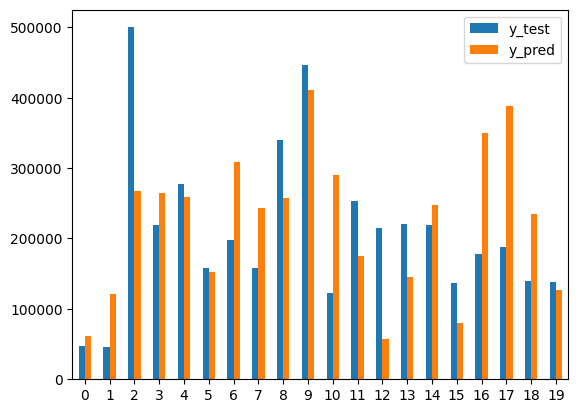

In [43]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score

def plot_predictions(y_test, housing_predictions, show=20, accuracy=False, plot=True):
    if not accuracy:
        print(f"RMSE: {root_mean_squared_error(y_test, housing_predictions)}")  # check the error
    else:
        print(f"Accuracy: {accuracy_score(y_test, housing_predictions)}")  # check the error
    if plot: pd.DataFrame({'y_test': y_test[:show].to_numpy(), 'y_pred': housing_predictions[:show]}, index=[x for x in range(show)]).plot.bar(rot=0)  # visualize some predictions

plot_predictions(y_test, housing_predictions)

# Are we satisfied?

This is better than nothing, but clearly not a great score: most districts’ `median_housing_values` range between 120K USD and  265K USD, so a typical prediction error of ~70K USD is not very satisfying.

This is an example of a model underfitting the training data.

# [Random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

A random forest fits decision trees on sub-samples of the dataset and uses averaging to improve accuracy and control over-fitting.

The sample size is controlled with `max_samples` if `bootstrap=True`, otherwise the whole dataset is used to build each tree.

RMSE: 50402.56458314594


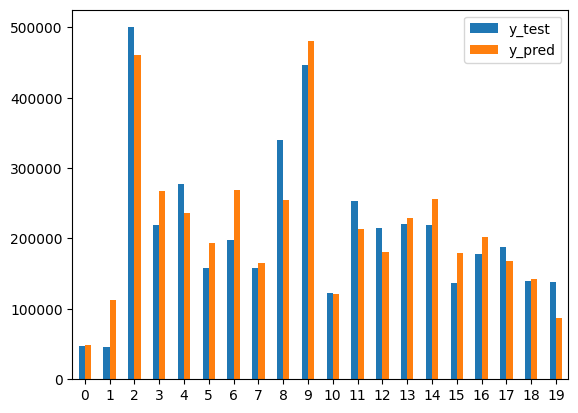

In [44]:
from sklearn.ensemble import RandomForestRegressor  # import the model

def run_forest(n_estimators, max_features, min_samples_split=5):
    forest_reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42, bootstrap=True)  # initialize the model (i.e., the estimator)
    forest_reg.fit(X_train, y_train)  # train it
    housing_predictions = forest_reg.predict(X_test)  # predict the cost of houses in the test set
    plot_predictions(y_test, housing_predictions)
    return forest_reg

forest_reg = run_forest(100, 1.0)

# Feature importance

In [45]:
feature_importance = forest_reg.feature_importances_
pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

,Feature,Importance
7,median_income,0.481621
12,ocean_proximity_INLAND,0.137495
8,population_per_household,0.121431
0,longitude,0.057869
1,latitude,0.056177
2,housing_median_age,0.044215
9,rooms_per_household,0.025773
10,bedrooms_per_room,0.024335
3,total_rooms,0.012644
4,total_bedrooms,0.012243


# Calculate the average `median_house_income` by `ocean_proximity`

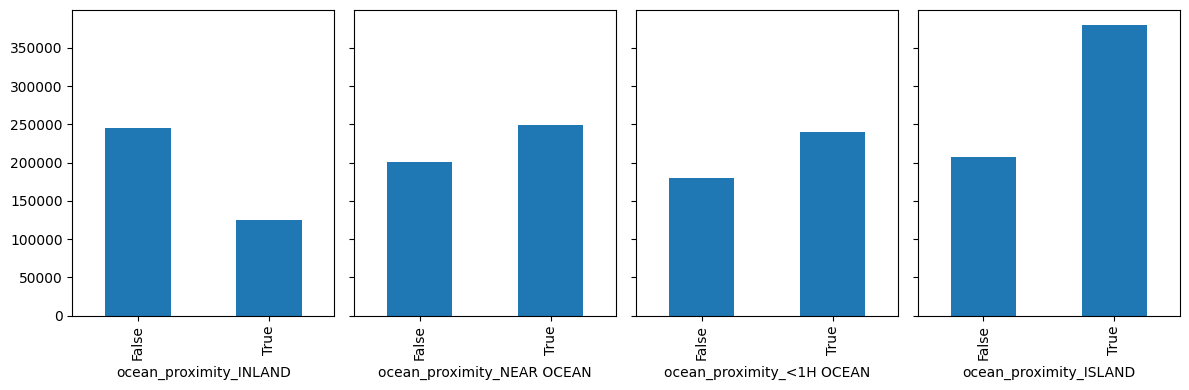

In [46]:
cur_df = preprocess(normalize=False)
fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)
for i, c in enumerate(['INLAND', 'NEAR OCEAN', '<1H OCEAN', 'ISLAND']):
    cur_df.groupby(f'ocean_proximity_{c}')['median_house_value'].mean().plot(kind="bar", ax=axs[i])
fig.tight_layout()

# Hyperparameters

Look at parameters used by our current forest

In [47]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# Hyperparameter optimization: random search

In [48]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'n_estimators': [2, 10, 25, 50, 100, 150],  # Number of trees in random forest
    'max_features': [1.0, 'sqrt'],  # Number of features to consider at every split
    'min_samples_split': [2, 5]
}

# Fit the random search model
rf_random = RandomizedSearchCV(estimator=forest_reg, param_distributions=random_grid, n_iter=5, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_features=1.0, min_samples_split=5, n_estimators=25; total time=   2.8s
[CV] END max_features=1.0, min_samples_split=5, n_estimators=25; total time=   2.6s
[CV] END max_features=1.0, min_samples_split=5, n_estimators=25; total time=   2.6s
[CV] END max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=2; total time=   0.2s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=2; total time=   0.3s
[CV] END max_features=1.0, min_samples_split=2, n_estimators=2; total time=   0.2s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=2; total time=   0.1s
[CV] END max_features=sqrt, min_samples_split=5, n_estimators=2; total time=   0.1s
[CV] END max_

{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt'}

# Running the best forest

RMSE: 49246.09927718297


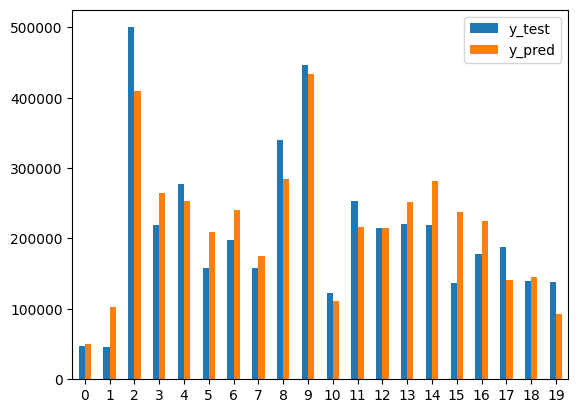

In [15]:
forest=run_forest(n_estimators=100, min_samples_split=2, max_features='sqrt')

# Trying SVM

In [49]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVR
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

# Initialize the SVR model
svr = SVR()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# Train the SVR model with the best parameters
best_svr = grid_search.best_estimator_

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] END .....C=0.1, epsilon=0.01, gamma=auto, kernel=linear; total time=   5.7s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   5.7s
[CV] END .....C=0.1, epsilon=0.01, gamma=auto, kernel=linear; total time=   5.7s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   5.8s
[CV] END .....C=0.1, epsilon=0.01, gamma=auto, kernel=linear; total time=   6.0s
[CV] END ......C=0.1, epsilon=0.01, gamma=scale, kernel=poly; total time=   6.3s
[CV] END .......C=0.1, epsilon=0.01, gamma=auto, kernel=poly; total time=   6.3s
[CV] END ....C=0.1, epsilon=0.01, gamma=scale, kernel=linear; total time=   6.4s
[CV] END ......C=0.1, epsilon=0.01, gamma=scale, kernel=poly; total time=   6.4s
[CV] END .......C=0.1, epsilon=0.01, gamma=auto, kernel=poly; total time=   6.4s
[CV] END .......C=0.1, epsilon=0.01, gamma=auto, kernel=poly; total time=   6.4s
[CV] END ......C=0.1, epsilon=0.01, gamma=scal

# Trying Neural Networks

In [50]:
from sklearn.neural_network import MLPRegressor

# Initialize the MLP Regressor with some hyperparameters
# mlp_regressor = MLPRegressor(activation='relu', hidden_layer_sizes=(32, 64, 128, 64, 8), solver='lbfgs', max_iter=20000) # Can take a long time to train (~1 hour)
mlp_regressor = MLPRegressor(activation='relu', hidden_layer_sizes=(32, 64, 128, 64, 8), solver='lbfgs', max_iter=20000)

# Train the MLP Regressor
mlp_regressor.fit(X_train, y_train)

# Predict on the test set
mlp_predictions = mlp_regressor.predict(X_test)

# Evaluate the model using RMSE
rmse = root_mean_squared_error(y_test, mlp_predictions)
print(f"RMSE: {rmse}")

RMSE: 121167.25247656947


# Dimensionality reduction: PCA

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
PC1,0.070980,-0.067685,-0.219824,0.483975,0.490013,0.473756,0.489898,0.049525,-0.003401,0.011990,-0.014875,0.015545,0.000314,-0.000060,-0.013946,-0.001854
PC2,-0.602965,0.619598,-0.078546,0.108086,0.013004,-0.020224,0.007564,0.210060,0.001121,0.266452,-0.291151,-0.141000,0.083521,-0.000177,0.081895,-0.024238


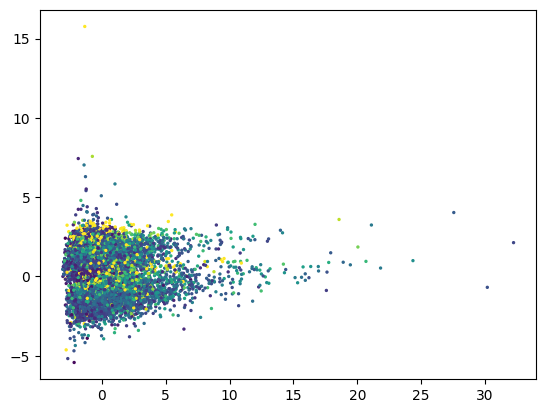

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result_pca = pca.fit_transform(X_train.values)
plt.scatter(x=result_pca[:, 0], y=result_pca[:, 1], c=y_train, s=2, cmap='viridis')
pd.DataFrame(pca.components_, columns=X_train.columns, index=['PC1', 'PC2'])

# Dimensionality reduction: TSNE

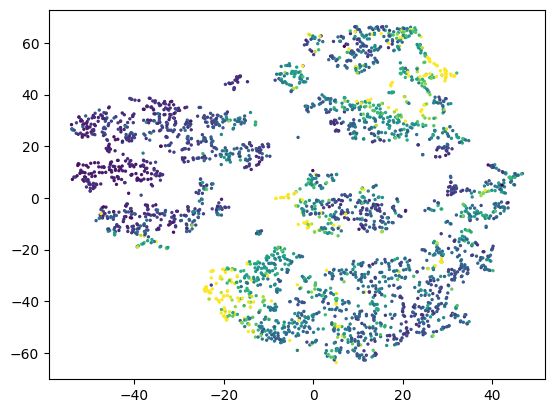

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
result_tsne = tsne.fit_transform(X_train.head(3000))

plt.scatter(x=result_tsne[:, 0], y=result_tsne[:, 1], c=y_train.head(3000), s=2, cmap='viridis')

# Classification

Can we turn this into a classification problem?

# Binning the `median_house_value` into 3 classes

<Axes: >

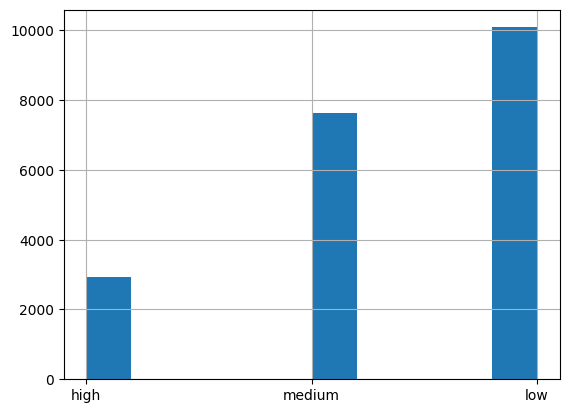

In [18]:
df = preprocess(False)  # clean the dataset withtout standardization
bins = ["low", "medium", "high"]  # the labels we are gonna use
# map bins of values into labels
df["median_house_value"] = pd.cut(df["median_house_value"], 3, labels=bins)
df["median_house_value"].hist()  # plot them


# Feature selection

For the sake of performance, we are going to use a manually defined set of features

In [19]:
y = df["median_house_value"]  # labels
# consider only some features from the train dataset
X = df[["latitude", "longitude", "median_income", "population", "households", "total_bedrooms"]]
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# PCA

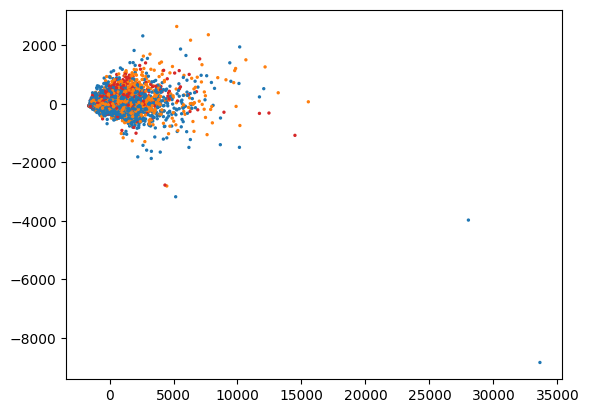

In [20]:
result_pca = pca.fit_transform(X_train.values)
def color(x):
    if x == "low": return "tab:blue"
    elif x == "medium": return "tab:orange"
    else: return "tab:red"
plt.scatter(x=result_pca[:, 0], y=result_pca[:, 1], c=y_train.apply(color), s=2)

# TSNE

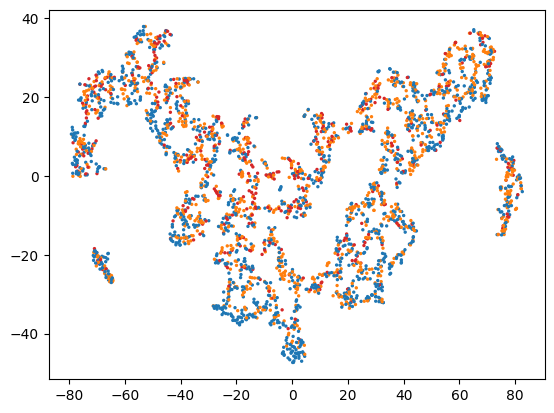

In [21]:
tsne = TSNE(n_components=2)
result_tsne = tsne.fit_transform(X_train.head(3000))
plt.scatter(x=result_tsne[:, 0], y=result_tsne[:, 1], c=y_train.head(3000).apply(color), s=2)

# Computing performance

:::: {.columns}
::: {.column width=70%}

![](https://user-images.githubusercontent.com/18005592/232803278-7a0e5182-4267-410a-a809-7edc54a47980.png)

:::
::: {.column width=30%}

![](https://user-images.githubusercontent.com/18005592/232803261-1cae7aac-e3fc-4467-bb45-65455d7a34a7.png)

:::
::::

Accuracy: $\frac{tp + tn}{tp + tn + fp + fpn}$; Precision: $\frac{tp}{tp + fp}$; Recall: $\frac{tp}{tp + fn}$; F1-score: $2 \cdot \frac{precision \cdot recall}{precision + recall}$

- Accuracy is used when TP and TN are more important while F1-score is used when FN and FP are
- Accuracy can be used when the class distribution is similar, while F1-score is a better when there are imbalanced classes


# Decision tree

In [22]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=42)
clf = clf.fit(X_train, y_train)
housing_predictions = clf.predict(X_test)
plot_predictions(y_test, housing_predictions, accuracy=True, plot=False)

Accuracy: 0.768349970640047


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, housing_predictions, target_names=bins))

              precision    recall  f1-score   support

         low       0.67      0.70      0.68       958
      medium       0.84      0.84      0.84      3303
        high       0.71      0.70      0.70      2551

    accuracy                           0.77      6812
   macro avg       0.74      0.75      0.74      6812
weighted avg       0.77      0.77      0.77      6812



In [24]:
feature_importance = clf.feature_importances_
pd.DataFrame({'Feature': X_train.columns,'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

,Feature,Importance
2,median_income,0.337024
1,longitude,0.254091
0,latitude,0.211648
3,population,0.072762
5,total_bedrooms,0.071925
4,households,0.052550


# Plotting the tree

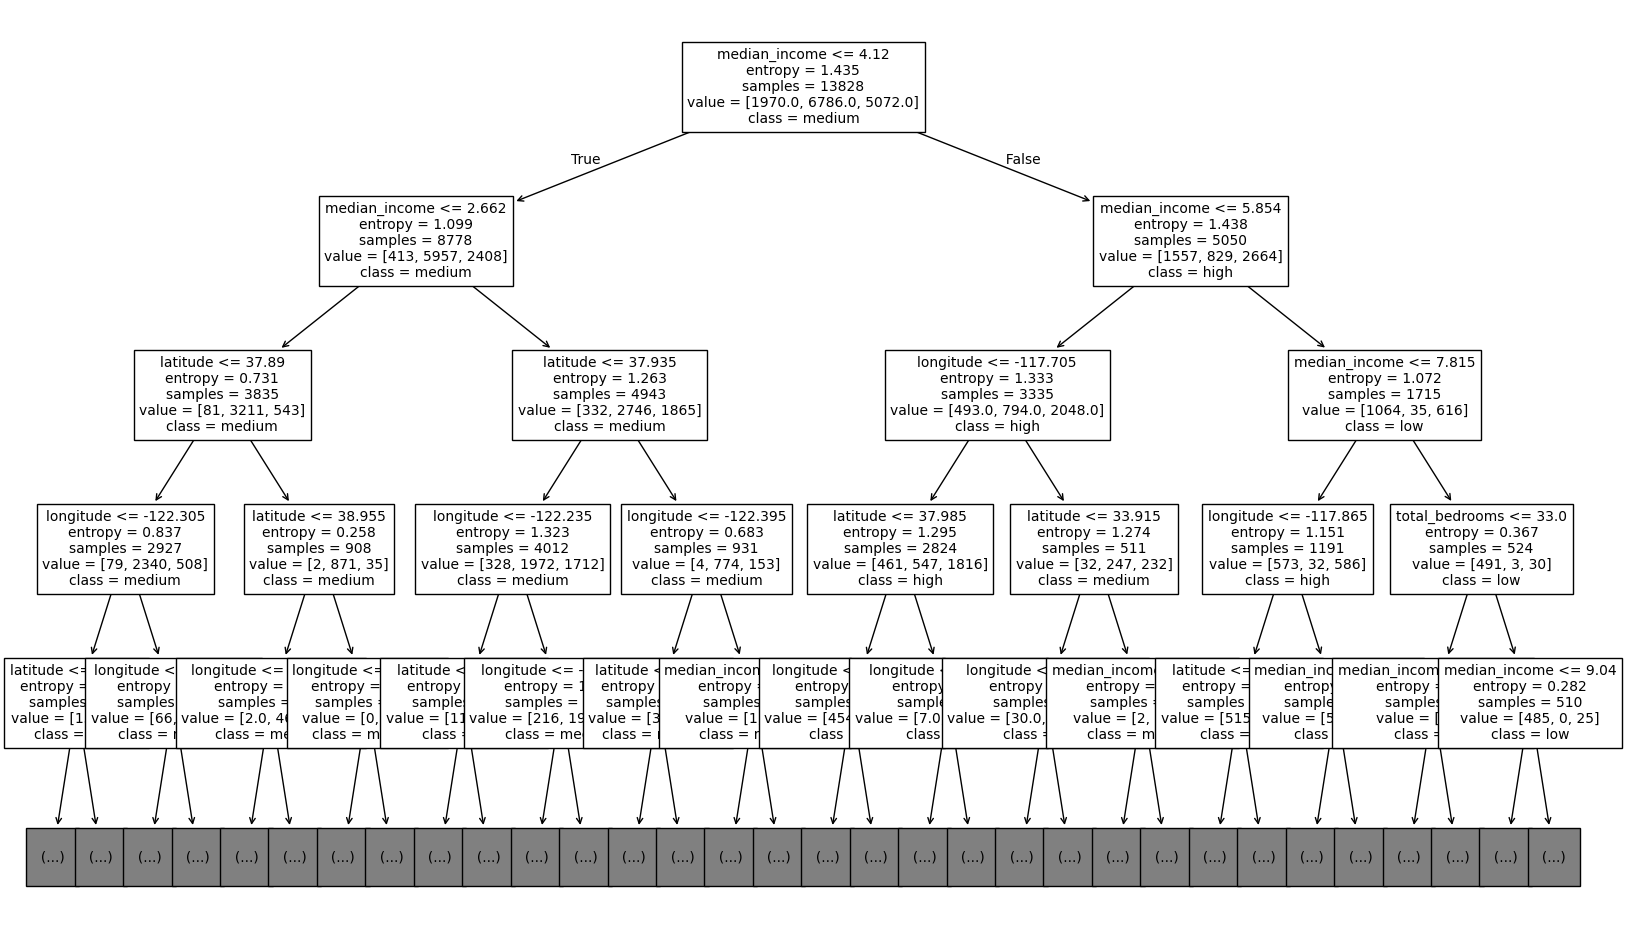

In [25]:
plt.figure(figsize=(20,12))
tree = tree.plot_tree(clf, fontsize=10, feature_names=X_train.columns, class_names=bins, max_depth=4)

# Random forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(criterion="entropy", random_state=42) # initialize the model
forest_cls = forest_cls.fit(X_train, y_train) # train it
plot_predictions(y_test, forest_cls.predict(X_test), accuracy=True, plot=False) # check the error

Accuracy: 0.8247210804462712


In [27]:
forest_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# Hyperparameter optimization

In [28]:
random_grid = {'n_estimators': [50, 100, 150], # Number of trees in random forest
               'max_features': [1.0, 'sqrt'], # Number of features to consider at every split
               'min_samples_leaf': [1, 5],
               'max_depth': [2, 5]
              }

rf_random = RandomizedSearchCV(estimator=forest_cls, param_distributions=random_grid, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.6s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.6s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   0.6s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=5, max_features=1.0, min_samples_leaf=5, n_estimators=100; total time=   2.1s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.5s
[CV] END max_depth=2, max_features=1.0, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_est

{'n_estimators': 100,
 'min_samples_leaf': 1,
 'max_features': 1.0,
 'max_depth': 5}

# Running the "best" forest

In [29]:
forest_cls = RandomForestClassifier(criterion="gini", random_state=42, n_estimators=50, max_features="sqrt", min_samples_leaf=1, max_depth=5)
forest_cls = forest_cls.fit(X_train, y_train) # train it
plot_predictions(y_test, forest_cls.predict(X_test), accuracy=True, plot=False)

Accuracy: 0.7298884321785085


In [30]:
forest_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# AutoML with [FLAML](https://microsoft.github.io/FLAML/docs/reference/automl/automl#automl-objects)

In [31]:
scale_mapper = {"low": 1, "medium": 2, "high": 3}
y_train = y_train.replace(scale_mapper)
y_test = y_test.replace(scale_mapper)
y_train

/tmp/ipykernel_18111/2541085399.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace(scale_mapper)
/tmp/ipykernel_18111/2541085399.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_train = y_train.replace(scale_mapper)
/tmp/ipykernel_18111/2541085399.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting'

5088     1
17096    3
5617     2
20060    1
895      2
        ..
11284    2
11964    1
5390     2
860      2
15795    2
Name: median_house_value, Length: 13828, dtype: category
Categories (3, int64): [1 < 2 < 3]

# Running AutoML

In [32]:
from flaml import AutoML

automl_settings = {
    "time_budget": 60,  # in seconds
    "metric": "accuracy",
    "task": "classification",
}

automl = AutoML()
automl.fit(X_train, y_train, **automl_settings)

[flaml.automl.logger: 03-25 16:02:37] {1728} INFO - task = classification
[flaml.automl.logger: 03-25 16:02:37] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 03-25 16:02:37] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 03-25 16:02:37] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 03-25 16:02:37] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 03-25 16:02:38] {2393} INFO - Estimated sufficient time budget=7251s. Estimated necessary time budget=168s.
[flaml.automl.logger: 03-25 16:02:38] {2442} INFO -  at 0.7s,	estimator lgbm's best error=0.3435,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 03-25 16:02:38] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-25 16:02:38] {2442} INFO -  at 1.2s,	estimator lgbm's best error=0.3435,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 03-2

# Running the best model

In [33]:
automl.model.estimator

/usr/local/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(colsample_bytree=np.float64(0.5967846088487322),
               learning_rate=np.float64(0.09348689572544734), max_bin=127,
               min_child_samples=4, n_estimators=73, n_jobs=-1, num_leaves=69,
               reg_alpha=np.float64(0.006958608037974516),
               reg_lambda=np.float64(0.001895876878997586), verbose=-1)

In [34]:
housing_predictions = automl.predict(X_test)
plot_predictions(y_test, housing_predictions, accuracy=True, plot=False)

Accuracy: 0.8373458602466236


# Exercise

In [35]:
# Can you do better?